# Abrir en `Google Colaboratory` y conectar con `Google Drive`

## Datos de Entrenamiento

In [ ]:
import pandas as pd

# Crea un DataFrame con los datos de entrenamiento
data = {'p1': [2, 3, 1], 
        'p2': [2, 3, 1], 
        'p3': [3, 2, 1],
        'p4': [1, 2, 3], 
        'p5': [3, 1, 2], 
        'p6': [1, 3, 2], 
        'p7': [3, 1, 2], 
        'p8': [3, 2, 1], 
        'p9': [3, 2, 1], 
        'p10': [2, 3, 1], 
        'p11': [1, 3, 2], 
        'p12': [3, 2, 1], 
        'p13': [2, 3, 1], 
        'p14': [1, 2, 3], 
        'p15': [1, 2, 3], 
        'p16': [3, 2, 1], 
        'p17': [1, 3, 2], 
        'p18': [1, 2, 3], 
        'p19': [1, 3, 2], 
        'p20': [1, 2, 3], 
        'p21': [3, 2, 1], 
        'p22': [1, 3, 2], 
        'p23': [1, 3, 2], 
        'p24': [1, 2, 3], 
        'p25': [1, 3, 2],  
        'p26': [1, 3, 2], 
        'p27': [1, 2, 3], 
        'p28': [3, 1, 2], 
        'p29': [1, 3, 2], 
        'p30': [1, 3, 2], 
        'p31': [1, 3, 2], 
        'p32': [3, 1, 2], 
        'p33': [1, 2, 3], 
        'p34': [2, 3, 1], 
        'area': ['fisico-matematicas', 'ciencias-sociales-salud', 'arte']}
df = pd.DataFrame(data)

# Guarda el DataFrame como un archivo CSV
df.to_csv('/content/drive/MyDrive/datos.csv', index=False)


## Creación y Entrenamiento del Modelo

Entrenando...
Modelo Entrenado!


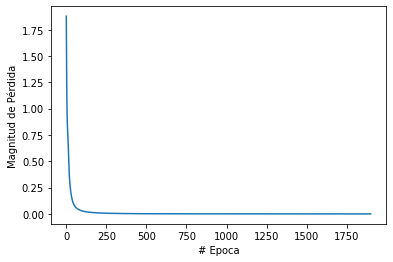

In [ ]:
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Carga de datos
df = pd.read_csv('/content/drive/MyDrive/datos.csv')
preguntas = df[['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13','p14','p15'
                ,'p16','p17','p18','p19','p20','p21','p22','p23','p24','p25','p26','p27','p28'
                ,'p29','p30','p31','p32','p33','p34']]
area = df['area']

# Codificación de etiquetas
encoder = LabelEncoder()
area_codificadas = encoder.fit_transform(area)
area_codificadas = to_categorical(area_codificadas) #convertimos las etiquetas a one hot encoding

# Creación del modelo
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(34,)), #la primera capa se encarga de aplanar las entradas
    keras.layers.Dense(64, activation='relu'), #capa densa de 64 neuronas con activación relu
    keras.layers.Dense(3, activation='softmax') #capa de salida con 3 neuronas y activación softmax para la clasificación
])

# Compilación del modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
print("Entrenando...")
historial = model.fit(preguntas, area_codificadas, epochs=1900, verbose=False)
print("Modelo Entrenado!")

plt.xlabel("# Epoca")
plt.ylabel("Magnitud de Pérdida")
plt.plot(historial.history["loss"])


## Pruebas `(Modificar email)`

In [ ]:
import os
import numpy as np
import firebase_admin
from firebase_admin import credentials
from google.cloud import firestore
import tensorflow as tf

email = 'mcorderol@ipn.mx'

# Use a service account.
if not firebase_admin._apps:
    cred = credentials.Certificate('/content/drive/MyDrive/univcon-64c3e-firebase-adminsdk-28aki-76008b008e.json') 
    default_app = firebase_admin.initialize_app(cred)

credential_path = os.path.abspath('/content/drive/MyDrive/univcon-64c3e-firebase-adminsdk-28aki-76008b008e.json')
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path

db = firestore.Client()

coleccion_ref = db.collection('preguntas')
query = coleccion_ref.where("email", "==", email)
docs = query.stream()

results_list = []
for doc in docs:
    data = doc.to_dict()
    new_data = {key: value for key, value in data.items() if key != 'email'}
    results_list.append(new_data)

results_list = sorted(results_list[0].items(), key=lambda x: int(x[0].replace("p", "")))

results_list = [val for key, val in results_list]

print("------------------------------------------------------------------------------------------------------")
print(results_list)

preguntas_prueba = [
   #  [1,1,1,3,2,2,2,1,1,1,2,1,1,3,3,1,2,3,2,3,1,2,2,3,2,2,3,2,2,2,2,2,3,1], # Arte
   #  [3,3,2,2,1,3,1,2,2,3,3,2,3,2,2,2,3,2,3,2,2,3,3,2,3,3,2,1,3,3,3,1,2,3], # Salud
   #  [2,2,3,1,3,1,3,3,3,2,1,3,2,1,1,3,1,1,1,1,3,1,1,1,1,1,1,3,1,1,1,3,1,2], # F-M
   #  [2,1,3,3,2,1,1,2,2,2,1,1,1,2,2,3,3,1,2,2,1,2,3,2,2,1,2,1,3,2,2,1,1,1], # Prueba Real
      results_list
]

preguntas_prueba = np.array(preguntas_prueba)

# Hacer predicciones con el modelo entrenado
predicciones = model.predict(preguntas_prueba)

# Obtener la clase con la probabilidad más alta para cada ejemplo
clases_predichas = np.argmax(predicciones, axis=1)
print("------------------------------------------------------------------------------------------------------")
print(clases_predichas)

correspondencia = {0: "Bellas Artes", 1: "Ciencias Sociales y de la Salud", 2: "Físico-Matemáticas"}
results_list = [correspondencia.get(val, val) for val in clases_predichas]
print(results_list)

universidades = [{"unv1":"Universidad Nacional Autónoma de México (UNAM)", "area":2},
                 {"unv2":"Instituto Politécnico Nacional (IPN)", "area":2},
                 {"unv3":"Instituto Tecnológico y de Estudios Superiores de Monterrey (ITESM)", "area":2},
                 {"unv4":"Universidad Autónoma Metropolitana (UAM)", "area":2},
                 {"unv5":"Universidad de Guadalajara (UdeG)", "area":2},
                 {"unv1":"Universidad Nacional Autónoma de México (UNAM)", "area":1},
                 {"unv2":"Instituto Politécnico Nacional (IPN)", "area":1},
                 {"unv3":"Instituto Tecnológico y de Estudios Superiores de Monterrey (ITESM)", "area":1},
                 {"unv4":"Universidad Autónoma Metropolitana (UAM)", "area":1},
                 {"unv5":"Universidad Iberoamericana (UIA)", "area":1},
                 {"unv1":"Universidad Nacional Autónoma de México (UNAM)", "area":0},
                 {"unv2":"Instituto Tecnológico y de Estudios Superiores de Monterrey (ITESM)", "area":0},
                 {"unv3":"Universidad Autónoma Metropolitana (UAM)", "area":0},
                 {"unv4":"Universidad de Guadalajara (UdeG)", "area":0},
                 {"unv5":"Universidad Veracruzana (UV)", "area":0}]


universidades_guardadas = [unv for unv in universidades if unv["area"] == int(clases_predichas[0])]


new_collection_ref = db.collection('informes')
new_collection_ref.add({
    'email' : email,
})

query = new_collection_ref.where("email", "==", email)
docs = query.docs = query.stream()
for doc in docs:
  doc.reference.update({'area': results_list})

query = new_collection_ref.where("email", "==", email)
docs = query.stream()
for doc in docs:
  for i in range(5):
      doc.reference.update({'unv'+str(i+1): universidades_guardadas[i]['unv'+str(i+1)]})


------------------------------------------------------------------------------------------------------
[2, 3, 1, 1, 1, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
1/1 [==============================] - 0s 15ms/step
------------------------------------------------------------------------------------------------------
[0]
['Bellas Artes']
